# Data Analysis:

### Required Libraries:

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt
import ptitprince as pt

# if you do not have any of the above libraries installed, run this:
# pip install -r requirements.txt

### Importing and pre-processing data:

In [72]:
df = pd.read_csv("PsyToolkitData_BRED_PROJECT_11_Nov/data.csv")
# print(df.columns)

def convert_group(a):
    if a == 1:
        return "walking"
    if a == 2:
        return "joystick"
    return "invalid"

def convert_gender(a):
    if a == 1:
        return "woman"
    if a == 2:
        return "man"
    return "other"

def preprocessing_data():
    df.loc[df["walking_time_1"].isna() & (df["psy_group"] == 1), "psy_group"] = 2
    df.loc[df["joystick_time_1"].isna() & (df["psy_group"] == 2), "psy_group"] = 1
    df["condition"] = df["psy_group"].apply(convert_group)
    df["gender"] = df["d_gender_1"].apply(convert_gender)

### Function to get General Statistics:

In [73]:
def list_stats(l, thing, condition=""):
    # Calculate statistics for walking
    mean = np.mean(l)
    median = np.median(l)
    mode = stats.mode(l, keepdims=True)[0][0]
    std_dev = np.std(l)

    # Calculate outliers for walking using IQR
    q1, q3 = np.percentile(l, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    outliers1 = [v for v in l if v < lower_bound or v > upper_bound]

    print(f"{condition}Statistics for {thing}:")
    print(f"Mean: {mean:.3f}")
    print(f"Median: {median:.3f}")
    print(f"Mode: {mode:.3f}")
    print(f"Standard Deviation: {std_dev:.3f}")
    print(f"Outliers: {outliers1}\n")

def lists_stats_wrapper(walking, joystick, thing):
    list_stats(walking, thing, "Walking ")
    list_stats(joystick, thing, "Joystick ")

### Functions to Plot Data:

In [74]:
def lists_boxplot(walking, joystick, label):
    # Plot combined box plot
    plt.boxplot([walking, joystick], vert=True, labels=['Walking', 'Joystick'])
    plt.title(f"Box Plots of {label} for each Condition")
    plt.ylabel(label)
    plt.xlabel("Condition")
    plt.show()
def lists_violinplot(walking, joystick, label):
    # Create a violin plot
    plt.figure(figsize=(6, 4))
    sns.violinplot(data=[walking, joystick], inner="box")
    plt.xticks(ticks=[0, 1], labels=['Walking', 'Joystick'])
    plt.title(f"Violin Plots of {label} for each Condition")
    plt.ylabel(label)
    plt.xlabel("Condition")
    plt.show()
def lists_raincloudplot(walking, joystick, label):
    # Create DataFrame for plotting
    data = pd.DataFrame({
        "Values": walking + joystick,
        "Condition": ["Walking"] * len(walking) + ["Joystick"] * len(joystick)
    })

    # Initialize figure
    fig, ax = plt.subplots(figsize=(8, 5))

    # Create raincloud plot
    pt.RainCloud(x="Condition", y="Values", data=data, palette="Set2", width_viol=0.8, ax=ax, orient='h', point_size=5)

    # Titles and labels
    plt.title(f"Raincloud Plot of {label} for each Condition")
    plt.ylabel(label)
    plt.xlabel("Condition")

    # Show plot
    plt.show()
def lists_histogram(walking, joystick, bins):

    plt.figure(figsize=(10, 6))
    plt.hist(walking, bins=bins, color="blue", alpha=0.5, edgecolor="black", label="Walking", align='left')
    plt.hist(joystick, bins=bins, color="red", alpha=0.5, edgecolor="black", label="Joystick", align='left')

    # Labels and title
    plt.xlabel("Number of Correct Objects")
    plt.ylabel("Frequency")
    plt.title("Histogram of Objects Correctly Placed for Each Condition")
    plt.xticks(range(5))  # Set x-ticks to be at each bin center for clarity
    plt.legend()
    plt.show()

### Functions for Analysis:

In [75]:
def demographic_analysis():
    print(f"Gender of Participants:\t"
          f"Women: {df['gender'].value_counts()['woman']},"
          f" Men: {df['gender'].value_counts()['man']}")
    print(f"Age of participants:"
          f"\tMean: {df['d_age_1'].mean():.3f}, SD: {df['d_age_1'].std():.3f}")
    print(f"Number of participants in each Condition:\n"
          f"\tWalking: {df['condition'].value_counts()['walking']}\n"
          f"\tJoystick: {df['condition'].value_counts()['joystick']}")
    print(f"Prior Experience in VR among Participants:\n"
          f"\tMean: {df['d_vr_experience_1'].mean():.3f}, SD: {df['d_vr_experience_1'].std():.3f}")
    print(f"Time Taken for Completion of Entire Experiment:"
          f"\n\tMean: {df['TIME_total'].mean():.3f}, SD: {df['TIME_total'].std():.3f}\n")

def calc_ssq_scores(scores):
    nausea = [1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1]
    oculomotor = [1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0]
    disorientation = [0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 2, 1, 0, 0]

    # Final score multiplier
    final_multiplier = 3.74

    total_scores = []
    for score in scores:
        # Calculate weighted sums for each category
        nausea_score = sum(s * w for s, w in zip(score, nausea))
        oculomotor_score = sum(s * w for s, w in zip(score, oculomotor))
        disorientation_score = sum(s * w for s, w in zip(score, disorientation))
        # Sum of all categories and apply final multiplier
        total_score = (nausea_score + oculomotor_score + disorientation_score) * final_multiplier
        total_scores.append(total_score)
    return total_scores

def ssq_analysis():
    v_question_columns = [col for col in df.columns if col.startswith('v_questions')]
    # Calculate the mean across 'v_questions' columns for each 'condition'
    ssq_walking, ssq_joystick = [], []
    for col in v_question_columns:
        ssq_walking.append(df[col][df['condition'] == 'walking'].tolist())
    for col in v_question_columns:
        ssq_joystick.append(df[col][df['condition'] == 'joystick'].tolist())
    walking_scores = calc_ssq_scores(ssq_walking)
    joystick_scores = calc_ssq_scores(ssq_joystick)
    lists_stats_wrapper(walking_scores, joystick_scores, "Simulator Sickness")
    lists_boxplot(walking_scores, joystick_scores, "Simulator Sickness")
    lists_violinplot(walking_scores, joystick_scores, "Simulator Sickness")
    # lists_raincloudplot(walking_scores, joystick_scores, "Simulator Sickness")

def presence_analysis():
    joystick_scores = df["presence_overall_1"][df["condition"] == 'joystick'].tolist()
    walking_scores = df["presence_overall_1"][df["condition"] == 'walking'].tolist()
    lists_stats_wrapper(walking_scores, joystick_scores, "Presence")
    lists_boxplot(walking_scores, joystick_scores,
                  "Overall Presence")
    lists_violinplot(walking_scores, joystick_scores,
                  "Overall Presence")
    # lists_raincloudplot(walking_scores, joystick_scores,
    #               "Overall Presence")

def task_performance():
    joystick_times = df["joystick_time_1"][df["condition"] == 'joystick'].tolist()
    walking_times = df["walking_time_1"][df["condition"] == 'walking'].tolist()
    lists_stats_wrapper(walking_times, joystick_times,
                "Time for Task Completion")
    lists_boxplot(walking_times, joystick_times,"Time Taken (in s)")
    lists_violinplot(walking_times, joystick_times,"Time Taken (in s)")
    # lists_raincloudplot(walking_times, joystick_times,"Time Taken (in s)")

    joystick_scores = df["joystick_score_1"][df["condition"] == 'joystick'].tolist()
    walking_scores = df["walking_score_1"][df["condition"] == 'walking'].tolist()
    lists_stats_wrapper(walking_scores, joystick_scores,
                "Objects Correctly Placed")
    lists_histogram(walking_scores, joystick_scores,
                    [0, 1, 2, 3, 4, 5])

def task_feedback_analysis():
    ### It is in order Poorly to Clearly, 1 to 5.
    w_clarity = df["w_clarity_1"][df["condition"] == 'walking'].tolist()
    j_clarity = df["j_clarity_1"][df["condition"] == 'joystick'].tolist()
    lists_stats_wrapper(w_clarity, j_clarity, "Clarity of Instructions")

    ### It is in order from difficult to easy, 1 to 5.
    w_difficulty = df["w_difficulty_1"][df["condition"] == 'walking'].tolist()
    j_difficulty = df["j_difficulty_1"][df["condition"] == 'joystick'].tolist()
    lists_stats_wrapper(w_difficulty, j_difficulty, "Difficulty of Task")

    ### It is in order from difficult/uncomfortable to easy/confortable, 1 to 4.
    w_navigation = df["w_navigation_1"][df["condition"] == 'walking'].tolist()
    j_navigation = df["j_navigation_1"][df["condition"] == 'joystick'].tolist()
    lists_stats_wrapper(w_navigation, j_navigation, "Ease of Navigation")

    ### Correlation between navigation and difficulty scores, for each condition:

    ### Analysis of Strategies used:
    w_strategy = df["w_strategy_1"][df["condition"] == 'walking'].tolist()
    j_strategy = df["j_strategy_1"][df["condition"] == 'joystick'].tolist()
    # print(w_strategy)
    # print(j_strategy)

## Analysis:

### 1) Demographic Analysis:

In [76]:
preprocessing_data()
demographic_analysis()

Gender of Participants:	Women: 10, Men: 30
Age of participants:	Mean: 19.425, SD: 0.931
Number of participants in each Condition:
	Walking: 20
	Joystick: 20
Prior Experience in VR among Participants:
	Mean: 1.700, SD: 0.823
Time Taken for Completion of Entire Experiment:
	Mean: 13.050, SD: 2.375



### 2) Simulator Sickness Analysis:

Walking Statistics for Simulator Sickness:
Mean: 5.984
Median: 3.740
Mode: 0.000
Standard Deviation: 6.077
Outliers: []

Joystick Statistics for Simulator Sickness:
Mean: 40.143
Median: 33.660
Mode: 33.660
Standard Deviation: 22.993
Outliers: []



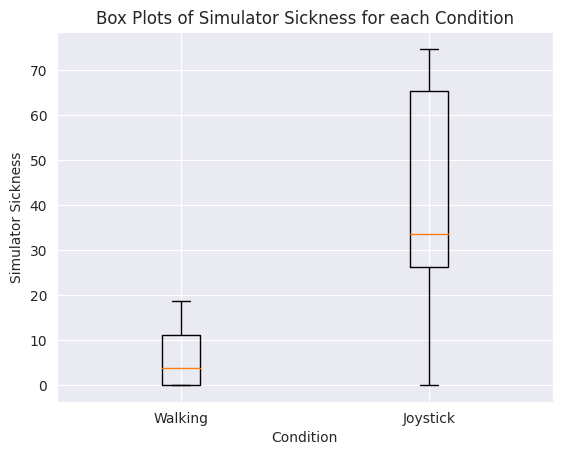

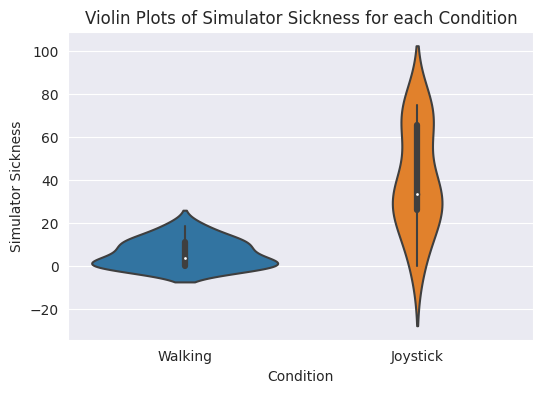

In [77]:
preprocessing_data()
ssq_analysis()

### 3) Presence Analysis:

Walking Statistics for Presence:
Mean: 6.100
Median: 6.090
Mode: 5.910
Standard Deviation: 0.372
Outliers: [5.09]

Joystick Statistics for Presence:
Mean: 5.150
Median: 5.225
Mode: 3.090
Standard Deviation: 1.064
Outliers: []



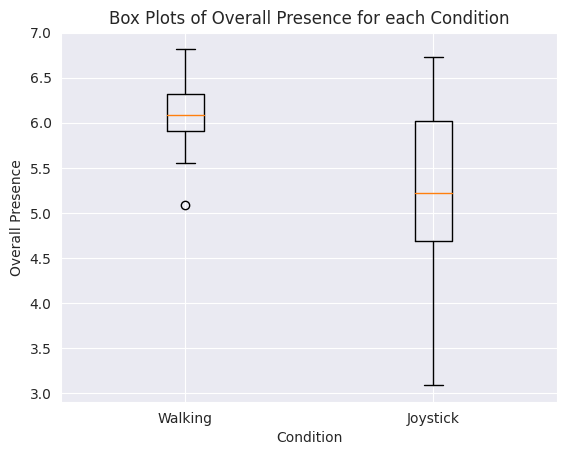

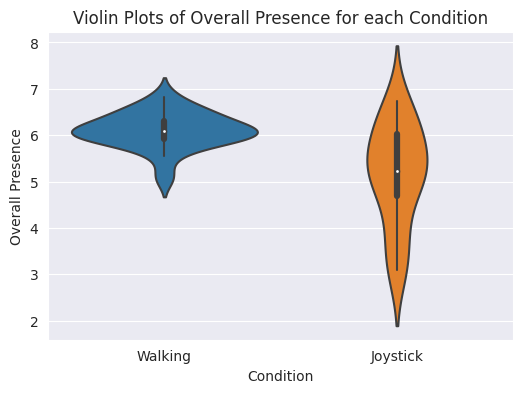

In [78]:
preprocessing_data()
presence_analysis()

### 4) Task Performance Analysis:

Walking Statistics for Time for Task Completion:
Mean: 44.078
Median: 44.405
Mode: 23.640
Standard Deviation: 11.594
Outliers: []

Joystick Statistics for Time for Task Completion:
Mean: 92.898
Median: 82.150
Mode: 48.770
Standard Deviation: 48.885
Outliers: [246.0]



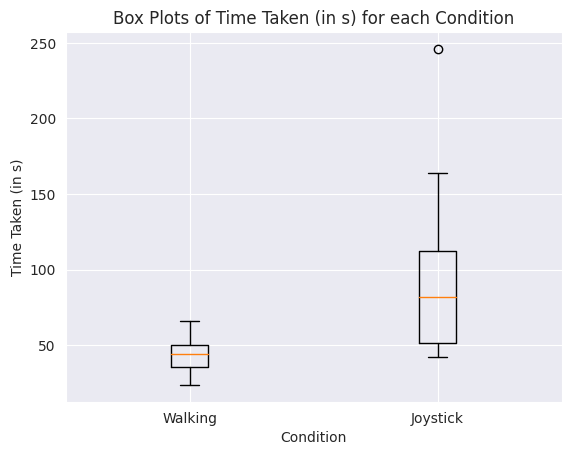

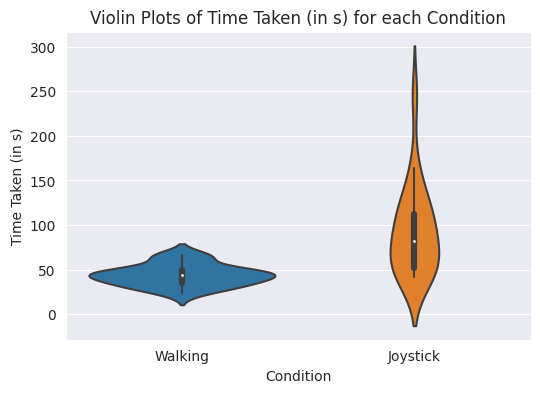

Walking Statistics for Objects Correctly Placed:
Mean: 3.900
Median: 4.000
Mode: 4.000
Standard Deviation: 0.436
Outliers: [2.0]

Joystick Statistics for Objects Correctly Placed:
Mean: 1.900
Median: 2.000
Mode: 2.000
Standard Deviation: 1.480
Outliers: []



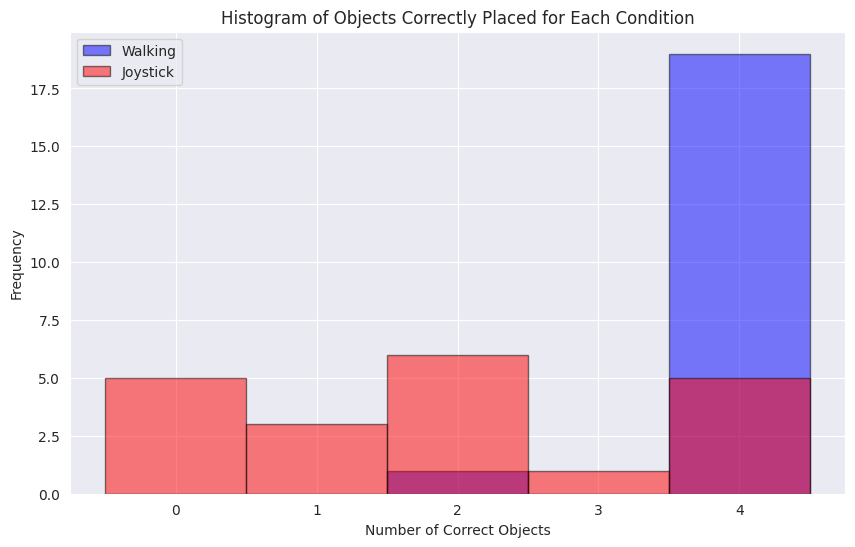

In [79]:
preprocessing_data()
task_performance()

### 5) Task Feedback Analysis:
**Main points have been summarized here, running the code is not mandatory:**
- For both conditions, the following feedback was taken:

  - **Clarity of Instructions:** 5-point lickert scale, from _very poorly explained_ to _very well-explained_
    - For both conditions, Almost everyone felt that the instructions were well-explained.

  - **Difficulty of Task:** 5-point lickert scale, from _very easy_ to _very difficult_
    - For **Walking** condition, Almost everyone found the task _very easy_.
    - For **Joystick** condition, the average consensus was that the task was _adequately difficulty_.

  - **Ease of Navigation:** 4-point lickert scale, from _very difficult/uncomfortable_ to _very easy/comfortable_.
    - For **Walking** condition, almost everyone found navigation _very easy/comfortable_.
    - For **Joystick** condition, average consensus was that movement was _slightly easy/comfortable_. However, the option _slightly difficult/uncomfortable_ was selected the most times (mode).

  - **Task Strategy:** This was subjective, participants were asked to explain the strategies they used to complete the task. **ANALYSIS YET TO BE DONE.**

- **Note:** Correlation between Difficulty of task and Ease of Navigation: **YET TO BE DONE.**

In [80]:
preprocessing_data()
task_feedback_analysis()

Walking Statistics for Clarity of Instructions:
Mean: 4.900
Median: 5.000
Mode: 5.000
Standard Deviation: 0.300
Outliers: [4.0, 4.0]

Joystick Statistics for Clarity of Instructions:
Mean: 4.550
Median: 5.000
Mode: 5.000
Standard Deviation: 0.805
Outliers: [2.0]

Walking Statistics for Difficulty of Task:
Mean: 1.500
Median: 1.000
Mode: 1.000
Standard Deviation: 0.592
Outliers: []

Joystick Statistics for Difficulty of Task:
Mean: 3.250
Median: 3.000
Mode: 3.000
Standard Deviation: 0.994
Outliers: []

Walking Statistics for Ease of Navigation:
Mean: 3.650
Median: 4.000
Mode: 4.000
Standard Deviation: 0.572
Outliers: []

Joystick Statistics for Ease of Navigation:
Mean: 2.650
Median: 2.000
Mode: 2.000
Standard Deviation: 0.853
Outliers: []



---

## Reliability Testing:

### Cronbach's Alpha:
- Done as a test for internal consistency of each condition (joystick and walking).
- Done for SSQ, and Presence Questionnaire. Not performed for task feedback or task performance since there are only 3 and 2 items respectively, for each condition.

### Function:

In [81]:
def cba_reliability(construct):
    constructs = {
        "Presence": {
            "joystick": df[['p_q1_1', 'p_q2_1', 'p_q3_1',
                            'p_q4_1', 'p_q5_1', 'p_q6_1',
                            'p_q7_1', 'p_q8_1', 'p_q9_1',
                            'p_q10_1', 'p_q11_1']][df['condition'] == 'joystick'],
            "walking": df[['p_q1_1', 'p_q2_1', 'p_q3_1',
                           'p_q4_1', 'p_q5_1', 'p_q6_1',
                           'p_q7_1', 'p_q8_1', 'p_q9_1',
                           'p_q10_1', 'p_q11_1']][df['condition'] == 'walking']
        },
        "Simulator Sickness": {
            "joystick": df[['v_questions_1', 'v_questions_2', 'v_questions_3',
                            'v_questions_4', 'v_questions_5', 'v_questions_6',
                            'v_questions_7', 'v_questions_8', 'v_questions_9',
                            'v_questions_10', 'v_questions_11', 'v_questions_12',
                            'v_questions_13', 'v_questions_14', 'v_questions_15'
                            ]][df['condition'] == 'joystick'],
            "walking": df[['v_questions_1', 'v_questions_2', 'v_questions_3',
                           'v_questions_4', 'v_questions_5', 'v_questions_6',
                           'v_questions_7', 'v_questions_8', 'v_questions_9',
                           'v_questions_10', 'v_questions_11', 'v_questions_12',
                           'v_questions_13', 'v_questions_14', 'v_questions_15'
                           ]][df['condition'] == 'walking']  },
    }
    df_j = constructs[construct]["joystick"]
    df_w = constructs[construct]["walking"]

    print(f"Reliability Analysis for {construct}:")
    print(f"\tCronbach Alpha for Joystick Condition: {pg.cronbach_alpha(df_j)[0]:.3f}\n"
          f"\tCronbach Alpha for Walking Condition: {pg.cronbach_alpha(df_w)[0]:.3f}\n")

def reliability_analysis():
    cba_reliability("Simulator Sickness")
    cba_reliability("Presence")

### Analysis:

In [82]:
preprocessing_data()
reliability_analysis()

Reliability Analysis for Simulator Sickness:
	Cronbach Alpha for Joystick Condition: 0.881
	Cronbach Alpha for Walking Condition: 0.802

Reliability Analysis for Presence:
	Cronbach Alpha for Joystick Condition: 0.903
	Cronbach Alpha for Walking Condition: 0.446



---

## Significance Testing:
- **Note:** Two tests were used, Mann-Whitney U and independent t-tests. Details are provided for the rationale behind them for each variable.

In [83]:
def analyze_data(walking, joystick, normality, label):
    print(f"{label}:")
    if normality:
        # One-tailed t-test
        t_stat, p_value = stats.ttest_ind(walking, joystick, alternative='greater')

        # Confidence interval for p-value (approximate using binomial proportion)
        n_tests = len(walking) + len(joystick)
        ci_low = max(0, p_value - 1.96 * np.sqrt((p_value * (1 - p_value)) / n_tests))
        ci_high = min(1, p_value + 1.96 * np.sqrt((p_value * (1 - p_value)) / n_tests))

        # Cohen's d
        mean_diff = np.mean(walking) - np.mean(joystick)
        pooled_std = np.sqrt((np.std(walking, ddof=1) ** 2 + np.std(joystick, ddof=1) ** 2) / 2)
        cohen_d = mean_diff / pooled_std

        # Confidence interval for Cohen's d (approximate)
        se_d = np.sqrt((1 / len(walking)) + (1 / len(joystick)))
        d_ci_low = cohen_d - 1.96 * se_d
        d_ci_high = cohen_d + 1.96 * se_d

        print(f"One-tailed t-test:")
        print(f"T-value: {t_stat:.6f}, P-value: {p_value:.6f}")
        print(f"Confidence Interval for P-value: [{ci_low:.6f}, {ci_high:.6f}]")
        print(f"Effect Size (Cohen's d): {cohen_d:.6f}")
        print(f"Confidence Interval for Effect Size: [{d_ci_low:.6f}, {d_ci_high:.6f}]")

    else:
        # Mann-Whitney U test (one-tailed, directional)
        u_stat, p_value = stats.mannwhitneyu(walking, joystick, alternative='greater')

        # Confidence interval for p-value (approximate)
        ci_low = max(0, p_value - 1.96 * np.sqrt((p_value * (1 - p_value)) / (len(walking) + len(joystick))))
        ci_high = min(1, p_value + 1.96 * np.sqrt((p_value * (1 - p_value)) / (len(walking) + len(joystick))))

        # Common Language Effect Size (probability that a random 'walking' value is greater than a random 'joystick' value)
        effect_size = u_stat / (len(walking) * len(joystick))

        # Confidence interval for effect size (approximate using normal approximation)
        se_effect = np.sqrt((effect_size * (1 - effect_size)) / (len(walking) * len(joystick)))
        es_ci_low = max(0, effect_size - 1.96 * se_effect)
        es_ci_high = min(1, effect_size + 1.96 * se_effect)

        print(f"Directional Mann-Whitney U test:")
        print(f"P-value: {p_value:.6f}")
        print(f"Confidence Interval for P-value: [{ci_low:.6f}, {ci_high:.6f}]")
        print(f"Effect Size (Common Language Effect Size): {effect_size:.6f}")
        print(f"Confidence Interval for Effect Size: [{es_ci_low:.6f}, {es_ci_high:.6f}]")

## 1) Task Performance:
### A) Time Taken to Complete the Task:
- We used the **Shapiro-Wilk test to test for normality** of times for joystick and walking conditions. We found the following results:

In [84]:
joystick_times = df["joystick_time_1"][df["condition"] == 'joystick'].tolist()
walking_times = df["walking_time_1"][df["condition"] == 'walking'].tolist()

_, pvalue = stats.shapiro(walking_times)
print(f"Normality of walking times (shapiro): {pvalue}")
_, pvalue = stats.shapiro(joystick_times)
print(f"Normality of joystick times (shapiro): {pvalue}")

Normality of walking times (shapiro): 0.49284082651138306
Normality of joystick times (shapiro): 0.005321241915225983


- Considering a threshold of p > 0.05, we observed that joystick times fell below it.
- However, after removing the outliers, we found that normality could be assumed:

In [85]:
# Remove outliers
joystick_times = np.array(joystick_times)[np.array(joystick_times) <= 230].tolist()

analyze_data(joystick_times, walking_times, True, "Time Taken")

# # Normality test
# x, pvalue = stats.shapiro(joystick_times)
# print(f"Normality of joystick times (outliers removed): {pvalue}")
#
# # Independent t-test
# _, pvalue = stats.ttest_ind(walking_times, joystick_times, equal_var=False)  # Welch’s t-test
# print(f"PValue (independent t-test): {pvalue}")
#
# # Effect size (Cohen's d)
# mean_diff = np.mean(walking_times) - np.mean(joystick_times)
# pooled_std = np.sqrt((np.std(walking_times, ddof=1) ** 2 + np.std(joystick_times, ddof=1) ** 2) / 2)
# cohen_d = mean_diff / pooled_std
#
# print(f"Effect size (Cohen's d): {cohen_d:.2f}")
#
# # Compute 95% Confidence Interval for Cohen’s d
# def cohen_d_ci(x, y, alpha=0.05, n_boot=1000):
#     boot_d = []
#     for _ in range(n_boot):
#         x_sample = np.random.choice(x, size=len(x), replace=True)
#         y_sample = np.random.choice(y, size=len(y), replace=True)
#         mean_diff = np.mean(x_sample) - np.mean(y_sample)
#         pooled_std = np.sqrt((np.std(x_sample, ddof=1) ** 2 + np.std(y_sample, ddof=1) ** 2) / 2)
#         boot_d.append(mean_diff / pooled_std)
#
#     lower, upper = np.percentile(boot_d, [(100 * alpha) / 2, 100 - (100 * alpha) / 2])
#     return lower, upper
#
# ci_lower, ci_upper = cohen_d_ci(walking_times, joystick_times)
# print(f"95% CI for Cohen's d: ({ci_lower:.2f}, {ci_upper:.2f})")

Time Taken:
One-tailed t-test:
T-value: 4.817493, P-value: 0.000012
Confidence Interval for P-value: [0.000000, 0.001117]
Effect Size (Cohen's d): 1.526531
Confidence Interval for Effect Size: [0.898623, 2.154440]


- **Final P-Value: p < 0.001.**

### B) Number of objects correctly placed:
- Similar Normality testing methods yielded that the data was not normally distributed. Hence, a non-parametric test: **Mann-Whitney U** was used instead.

In [86]:
# Extract scores
joystick_scores = df["joystick_score_1"][df["condition"] == 'joystick'].tolist()
walking_scores = df["walking_score_1"][df["condition"] == 'walking'].tolist()

# Normality tests
_, pvalue = stats.shapiro(walking_scores)
print(f"Normality of walking scores: {pvalue}")
_, pvalue = stats.shapiro(joystick_scores)
print(f"Normality of joystick scores: {pvalue}")

analyze_data(walking_scores, joystick_scores, False, "Objects Correctly Placed:")

# # Mann-Whitney U test
# U_stat, pvalue = stats.mannwhitneyu(walking_scores, joystick_scores, alternative='two-sided')
# print(f"PValue (Mann-Whitney U): {pvalue}")
#
# # Rank-Biserial Correlation (r)
# N = len(walking_scores) + len(joystick_scores)
# Z = stats.norm.ppf(pvalue / 2) * -1  # Convert p-value to Z-score
# rank_biserial_r = Z / np.sqrt(N)
# print(f"Effect Size (Rank-Biserial Correlation r): {rank_biserial_r:.2f}")
#
# # Cliff's Delta
# def cliffs_delta(x, y):
#     """Compute Cliff's Delta effect size."""
#     x, y = np.array(x), np.array(y)
#     n_x, n_y = len(x), len(y)
#     delta = (np.sum(x[:, None] > y) - np.sum(x[:, None] < y)) / (n_x * n_y)
#     return delta
#
# cliffs_d = cliffs_delta(walking_scores, joystick_scores)
# print(f"Effect Size (Cliff’s Delta δ): {cliffs_d:.2f}")
#
# # Confidence Interval for Cliff’s Delta (Bootstrapping)
# def bootstrap_cliffs_delta(x, y, n_boot=1000, ci=95):
#     deltas = []
#     for _ in range(n_boot):
#         x_sample = np.random.choice(x, size=len(x), replace=True)
#         y_sample = np.random.choice(y, size=len(y), replace=True)
#         deltas.append(cliffs_delta(x_sample, y_sample))
#     lower, upper = np.percentile(deltas, [(100 - ci) / 2, 100 - (100 - ci) / 2])
#     return lower, upper
#
# ci_lower, ci_upper = bootstrap_cliffs_delta(walking_scores, joystick_scores)
# print(f"Cliff’s Delta 95% CI: ({ci_lower:.2f}, {ci_upper:.2f})")

Normality of walking scores: 2.6930604413166748e-09
Normality of joystick scores: 0.009139131754636765
Objects Correctly Placed::
Directional Mann-Whitney U test:
P-value: 0.000006
Confidence Interval for P-value: [0.000000, 0.000745]
Effect Size (Common Language Effect Size): 0.858750
Confidence Interval for Effect Size: [0.824619, 0.892881]


- **Final p-value: p < 0.001.**

## 2) Presence:
- Presence scores **showed normality** within the threshold. Hence, **Independent T-test** was used:

In [87]:
# Extract presence scores
joystick_presence = df["presence_overall_1"][df["condition"] == 'joystick'].tolist()
walking_presence = df["presence_overall_1"][df["condition"] == 'walking'].tolist()

# Normality tests
_, pvalue = stats.shapiro(walking_presence)
print(f"Normality of walking presence: {pvalue}")
_, pvalue = stats.shapiro(joystick_presence)
print(f"Normality of joystick presence: {pvalue}")

analyze_data(walking_presence, joystick_presence, True, "Sense of Presence")

# # Independent t-test (Welch’s t-test for unequal variances)
# _, pvalue = stats.ttest_ind(walking_presence, joystick_presence, equal_var=False)
# print(f"PValue (t-test): {pvalue}")
#
# # Compute Cohen's d
# mean_diff = np.mean(walking_presence) - np.mean(joystick_presence)
# pooled_std = np.sqrt((np.std(walking_presence, ddof=1) ** 2 + np.std(joystick_presence, ddof=1) ** 2) / 2)
# cohen_d = mean_diff / pooled_std
# print(f"Effect size (Cohen's d): {cohen_d:.2f}")
#
# # Compute 95% CI for Cohen’s d using bootstrapping
# def cohen_d_ci(x, y, alpha=0.05, n_boot=1000):
#     boot_d = []
#     for _ in range(n_boot):
#         x_sample = np.random.choice(x, size=len(x), replace=True)
#         y_sample = np.random.choice(y, size=len(y), replace=True)
#         mean_diff = np.mean(x_sample) - np.mean(y_sample)
#         pooled_std = np.sqrt((np.std(x_sample, ddof=1) ** 2 + np.std(y_sample, ddof=1) ** 2) / 2)
#         boot_d.append(mean_diff / pooled_std)
#
#     lower, upper = np.percentile(boot_d, [(100 * alpha) / 2, 100 - (100 * alpha) / 2])
#     return lower, upper
#
# ci_lower, ci_upper = cohen_d_ci(walking_presence, joystick_presence)
# print(f"95% CI for Cohen's d: ({ci_lower:.2f}, {ci_upper:.2f})")

Normality of walking presence: 0.3697267174720764
Normality of joystick presence: 0.2210817039012909
Sense of Presence:
One-tailed t-test:
T-value: 3.673736, P-value: 0.000367
Confidence Interval for P-value: [0.000000, 0.006301]
Effect Size (Cohen's d): 1.161737
Confidence Interval for Effect Size: [0.541931, 1.781544]


- Final p-value: **p < 0.001.**

## 3) Simulator Sickness:
- Normality of **walking was not found**. Since there were no outliers detected using IQR method, we chose to do **Mann-Whitney U test** for significance:

In [88]:
import bootstrapped.bootstrap as bs
import bootstrapped.stats_functions as bs_stats

# Assuming df is your DataFrame and calc_ssq_scores is a predefined function

v_question_columns = [col for col in df.columns if col.startswith('v_questions')]

# Calculate the mean across 'v_questions' columns for each 'condition'
ssq_walking, ssq_joystick = [], []
for col in v_question_columns:
    ssq_walking.append(df[col][df['condition'] == 'walking'].tolist())
for col in v_question_columns:
    ssq_joystick.append(df[col][df['condition'] == 'joystick'].tolist())

walking_scores = calc_ssq_scores(ssq_walking)
joystick_scores = calc_ssq_scores(ssq_joystick)

# Normality tests
_, pvalue_walking = stats.shapiro(walking_scores)
print(f"Normality of walking SSQ scores: {pvalue_walking}")
_, pvalue_joystick = stats.shapiro(joystick_scores)
print(f"Normality of joystick SSQ scores: {pvalue_joystick}")

analyze_data(joystick_scores, walking_scores, False, "Simulator Sickness")

# # Mann-Whitney U test
# u_statistic, pvalue = stats.mannwhitneyu(walking_scores, joystick_scores)
# print(f"PValue (Mann-Whitney U): {pvalue}")
#
# # Cliff's Delta calculation
# def cliffs_delta(x, y):
#     n1, n2 = len(x), len(y)
#     greater = sum(1 for i in x for j in y if i > j)
#     lesser = sum(1 for i in x for j in y if i < j)
#     return (greater - lesser) / (n1 * n2)
#
# delta = cliffs_delta(walking_scores, joystick_scores)
# print(f"Cliff's Delta: {delta}")
#
# # Bootstrapped confidence interval for Cliff's Delta
# def bootstrap_cliffs_delta(x, y, num_samples=1000):
#     deltas = []
#     for _ in range(num_samples):
#         sample_x = np.random.choice(x, size=len(x), replace=True)
#         sample_y = np.random.choice(y, size=len(y), replace=True)
#         deltas.append(cliffs_delta(sample_x, sample_y))
#     return np.percentile(deltas, [2.5, 97.5])
#
# ci_cliffs_delta = bootstrap_cliffs_delta(walking_scores, joystick_scores)
# print(f"Confidence Interval for Cliff's Delta: {ci_cliffs_delta}")


Normality of walking SSQ scores: 0.02404071018099785
Normality of joystick SSQ scores: 0.15694966912269592
Simulator Sickness:
Directional Mann-Whitney U test:
P-value: 0.000030
Confidence Interval for P-value: [0.000000, 0.001978]
Effect Size (Common Language Effect Size): 0.928889
Confidence Interval for Effect Size: [0.895306, 0.962472]


- Final p-value: **p < 0.001.**